In [1]:
import gpflow
import tensorflow as tf
tf.config.run_functions_eagerly(True)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import os

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = ci_niter(2000)

# Simulate Patient Trajectories with Group Structure

## Parameters

In [21]:
N = 40 # number of patients
n_clusters = 4  # number of clusters

# Group level parameters
sigma_g = np.random.uniform(0.5, 1.2, n_clusters)
alpha_g = np.random.uniform(0.5, 1.2, n_clusters)

# Patient level parameters
alpha_i = np.random.uniform(0.3, 2, N)
sigma_i = np.random.uniform(0.3, 2, N)

print("alpha_g's", alpha_g)
print("sigma_g's", sigma_g)

alpha_g's [0.66257963 0.68428441 0.54579478 1.03442143]
sigma_g's [0.87089962 0.74153763 1.19036074 0.75604002]


## Kernels

In [22]:
Kg = []
for i in range(n_clusters):
    Kg.append(gpflow.kernels.Matern12(variance=sigma_g[i], lengthscales=alpha_g[i]))

Kf = []
for i in range(N):
    Kf.append(gpflow.kernels.Matern52(variance=sigma_i[i], lengthscales=alpha_i[i]))

## Generate $X, Y$

In [23]:
X = [] 
Y = [] 
cluster_assignments_dict = dict()
cluster_assignments_list = []

for i in range(N):
    M = np.random.randint(30, 40)
    max_t = np.random.randint(15, 20)

    x = np.linspace(0, max_t, M, endpoint=True)
    dist = (x[1]-x[0])/4
    x[1:] += np.random.uniform(-dist, dist, M-1)
    X.append(x)
    Sigma = Kf[i].K(np.expand_dims(X[i], 1))
    cluster_id = [np.random.choice([0, 1]), np.random.choice([2, 3])]
    cluster_assignments_dict[i] = cluster_id
    if cluster_id == [0, 2]:
        cluster_assignments_list.append(0)
    elif cluster_id == [0, 3]:
        cluster_assignments_list.append(1)
    elif cluster_id == [1, 2]:
        cluster_assignments_list.append(2)
    elif cluster_id == [1, 3]:
        cluster_assignments_list.append(3)


    for g in np.random.choice(np.arange(4), size=2):
        Sigma += Kg[g].K(np.expand_dims(X[i], 1))
    
    Y.append(np.random.multivariate_normal(mean=np.zeros(M), cov=Sigma, size=1).flatten())
    
for j in range(len(Y)):
    noise = np.random.normal(0, 0.1, size=Y[j].shape)
    Y[j] = Y[j] + noise

### Save to file

In [27]:
import pickle

np.save('simulated_Y.npy', Y, allow_pickle=True)
np.save('simulated_X.npy', X, allow_pickle=True)
np.save('simulated_cluster_assignments_list.npy', cluster_assignments_list, allow_pickle=True)
with open('simulated_cluster_assignments_dict.pkl', 'wb') as f:
    pickle.dump(cluster_assignments_dict, f, pickle.HIGHEST_PROTOCOL)

Text(0.5, 1.0, 'Two sample patient trajectories')

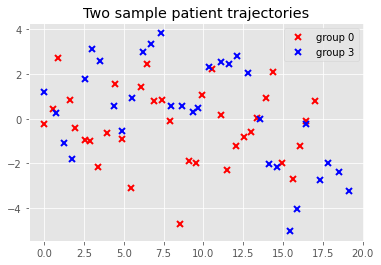

In [26]:
plt.plot(X[0], Y[0], "kx", mew=2, color='red', label='group 0')
plt.plot(X[-1], Y[-1], "kx", mew=2, color='blue', label='group 3')
plt.legend()
plt.title('Two sample patient trajectories')